# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [ ]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
!pip install ipywidgets

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert data to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the data
])

# Create training set and define training dataloader
training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**JUSTIFICATION**


1) I created a transformation in the first line. This transformation converts the images to PyTorch Tensor, normalize the data and flattens the mulit-dimensional data to a one-dimensional tensor which will be needed in our first layer.

2) The second and third steps are for data initialization, we apply the transformations to the data init stage

3) The last two steps are to create a data loader, we shuffle the training dataset and we use a batch si"ze to speed up training process

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [ ]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [ ]:
class Network(nn.Module):
    def __init__(self):
        """
        Initialise network
        """
        super().__init__()
        self.activation = F.relu # activation for hidden layer
        self.layer1 = nn.Linear(28 * 28 * 1, 512)  # MNIST dataset has one channel and is 28 by 28 in size(width, height)
        self.layer2 = nn.Linear(512, 120)
        self.layer3 = nn.Linear(120, 64)
        self.layer4 = nn.Linear(64, 10) # we have 10 classes to predict (0 - 9)
        
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

# initialise the network
network = Network()
network.to(device)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
# Choosing an optimizer
# optimizer = optim.Adam(network.parameters(), lr=0.001)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

# Choose a loss function, multi-class classification
criterion = nn.CrossEntropyLoss()

I used this `optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)`. It seemed to perform better than `optimizer = optim.Adam(network.parameters(), lr=0.001)`.

Though interestingly, interstingly, the test accuracy on test set is `97.86%` for SGD and `97.16%` for Adam

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [19]:

num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    network.train()
    train_loss = 0.0
    train_correct = 0

    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = network(inputs)
        loss = criterion(outputs, labels)

        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward() # calc grad
        optimizer.step() # take the backward step

        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_correct = 0
    network.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = network(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))


Epoch 1 training accuracy: 31.87% training loss: 0.01186
Epoch 1 validation accuracy: 31.23% validation loss: 0.10649
Epoch 2 training accuracy: 31.90% training loss: 0.00943
Epoch 2 validation accuracy: 31.25% validation loss: 0.09748
Epoch 3 training accuracy: 31.82% training loss: 0.01803
Epoch 3 validation accuracy: 31.15% validation loss: 0.10652
Epoch 4 training accuracy: 31.85% training loss: 0.01276
Epoch 4 validation accuracy: 31.26% validation loss: 0.10458
Epoch 5 training accuracy: 31.88% training loss: 0.01220
Epoch 5 validation accuracy: 31.32% validation loss: 0.09199
Epoch 6 training accuracy: 31.89% training loss: 0.01141
Epoch 6 validation accuracy: 31.34% validation loss: 0.09591
Epoch 7 training accuracy: 31.86% training loss: 0.01220
Epoch 7 validation accuracy: 31.30% validation loss: 0.10662
Epoch 8 training accuracy: 31.90% training loss: 0.00937
Epoch 8 validation accuracy: 31.35% validation loss: 0.09505
Epoch 9 training accuracy: 31.95% training loss: 0.00492

Plot the training loss (and validation loss/accuracy, if recorded).

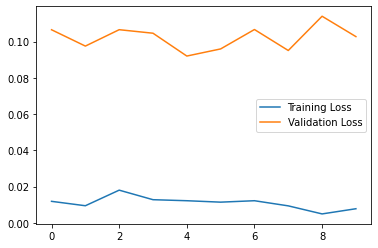

In [22]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [23]:
correct = 0
total = 0
network.eval()  # Set the network to evaluation mode

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:

        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the highest probability prediction

        total += labels.size(0)  # Increment the total count by the batch size
        correct += (predicted == labels).sum().item()  # Count the number of correct predictions

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.12%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [60]:
# optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# # Choose a loss function, multi-class classification
# criterion = nn.CrossEntropyLoss()

## Saving your model
Using `torch.save`, save your model for future loading.

In [24]:
torch.save(network.state_dict(), 'model.pth')

In [ ]:
!pwd